In [1]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from point import Point

Same pool of trials for all participants (static), with different shuffling (dynamic).

---

# Static Layout Pool
This refers to the generation of the layout pool, which will is the same for ALL participants.

## Generation

- Given N trials, we produce  N/2 pairs of layouts.
    - Between these pairs, we keep the same coordinates for the points, and the same order of navigation.
    - One of these pairs is the no-boundary-show, the other is the boundary-shown. The layout is rotated between these two.
    - Per layout, we have 5 objects and an ending location. The first object is also the starting location and might be asked.
    - We do not want any 2 objects to be too close to each other.
    - We do not want any path to be too short. We do not have an upper bound on the travel distance.
    - We want to to make sure that there is at least one object on both sides.

In [2]:
N_POINTS_LAYOUT = 6 # 5 objects, one of which is the starting location, and an ending location
N_LAYOUTS = 50 # generate this many layouts. each layout produces a pair (visible/invisible boundary)

# these are currently arbitrary units that we can scale up and down as needed
# w=5, l=10 represents a 1 by 2 rectangle room
WIDTH = 5 
LENGTH = 10

ASPECT = LENGTH / WIDTH

# this is the minimum distance any two objects (not a path) can have. 
# used to prevent objects appearing too close and confusing participants
MIN_DIST_OBJECTS = 1.5

# this is the minimum path distance. no subsequent object should appear closer than this.
# greater than MIN_DIST_OBJECTS because objects appearing too close also means they are visited too soon and not enough time to learn that object
MIN_DIST_PATH = 2.3

In [3]:
def generate_random_layout():
    return [Point.random_rect(WIDTH, LENGTH) for p in range(N_POINTS_LAYOUT)]

def has_valid_margin(p):
    buffer = 0.05
    x_lo = buffer * WIDTH
    x_hi = (1 - buffer) * WIDTH
    
    y_lo = buffer * LENGTH
    y_hi = (1 - buffer) * LENGTH
    
    border_lo = (LENGTH / 2) - LENGTH * buffer
    border_hi = (LENGTH / 2) + LENGTH * buffer
    
    bufferFromBoundary = (x_lo < p.x < x_hi) and (y_lo < p.y < y_hi)
    bufferFromBorder = not (border_lo < p.y < border_hi)
    
    return bufferFromBoundary and bufferFromBorder

def is_valid_layout(lay):
    
    # check all distance constraints, (dist between objects and path distances)
    for i in range(len(lay)):
        for j in range(i):
            # if these points are adjacent, check for path distance condition, otherwise object distance condition
            lower_bound = MIN_DIST_PATH if j == i - 1 else MIN_DIST_OBJECTS
            if lay[i].dist(lay[j]) <= lower_bound:
                return False
    
    # check that there is at least one object on each side
    # note that this checks for objects ONLY (that is; not the last point which is the ending/task location)
    objects_on_lower_side = sum([1 if l.y < LENGTH / 2 else 0 for l in lay[:N_POINTS_LAYOUT-1]])
    if not ( 1 <= objects_on_lower_side < N_POINTS_LAYOUT-1):
        # either 0 or N_POINTS_LAYOUT-1 on this side, which means the reverse for the other side. not valid!
        return False
    
    for p in lay:
        if not has_valid_margin(p):
            return False
    
    return True

def generate_valid_layout():
    candidate = generate_random_layout()
    c = 0
    while not is_valid_layout(candidate):
        c += 1
        if c == 1e5:
            print("can not find valid layout!")
            return None
        candidate = generate_random_layout()
    return candidate

In [4]:
layouts = []
for l in range(N_LAYOUTS):
    layouts.append(generate_valid_layout())

In [5]:
print(layouts)

[[P(4.03, 8.93), P(1.85, 1.68), P(4.53, 3.49), P(3.72, 0.55), P(0.87, 4.09), P(3.37, 6.41)], [P(1.26, 7.74), P(3.07, 4.46), P(4.11, 8.76), P(1.43, 5.8), P(1.64, 1.35), P(3.55, 7.24)], [P(3.58, 6.17), P(3.9, 8.52), P(0.63, 8.64), P(2.65, 4.01), P(2.21, 7.48), P(1.57, 1.59)], [P(0.29, 9.12), P(3.74, 4.34), P(4.56, 8.85), P(1.7, 7.33), P(1.91, 2.34), P(4.14, 7.37)], [P(2.26, 9.33), P(2.0, 5.75), P(0.33, 9.4), P(4.62, 1.02), P(1.41, 2.13), P(3.84, 3.3)], [P(1.02, 6.02), P(4.12, 8.9), P(1.44, 8.54), P(3.94, 3.88), P(0.33, 3.5), P(4.08, 2.16)], [P(2.32, 6.14), P(4.66, 1.72), P(1.89, 2.97), P(0.4, 6.09), P(2.02, 8.02), P(1.25, 1.27)], [P(4.36, 1.91), P(2.99, 4.17), P(2.55, 8.48), P(2.37, 0.83), P(4.44, 5.87), P(1.53, 7.22)], [P(1.44, 3.04), P(0.85, 7.49), P(4.31, 1.05), P(3.55, 8.35), P(0.35, 1.02), P(2.96, 6.42)], [P(3.79, 7.46), P(2.16, 3.98), P(3.77, 0.71), P(4.39, 3.99), P(3.63, 9.0), P(1.23, 8.9)], [P(2.13, 6.83), P(4.43, 0.83), P(0.97, 5.68), P(1.83, 2.16), P(2.36, 8.54), P(4.75, 7.28)]

## Checks
- We want to check for the following distributions:
    - Pointing ground-truths -> compare those in the same side and across the boundary.
    - How much they have traveled
    - Distances between any two objects
    
- And the following are nice sanity checks to have:
    - Plot of all layouts
    - Plot of all points

In [6]:
# Ground Truth for Pointing Tasks (GTPT)
gtpt_same = []
gtpt_cross = []

for lay in layouts:
    last = lay[-1]
    last_side = last.y < LENGTH / 2
    
    for obj in lay[:-1]:
        is_on_same_side = last_side == (obj.y < LENGTH / 2)
        dist = last.dist(obj)
        if is_on_same_side:
            gtpt_same.append(dist)
        else:
            gtpt_cross.append(dist)

gtpt_all = [gtpt_same, gtpt_cross]
print(len(gtpt_same), "same side; ", len(gtpt_cross), "across boundary")

112 same side;  138 across boundary


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


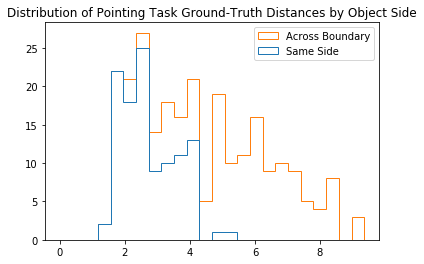

In [7]:
plt.hist(gtpt_all, bins = 24, range = [0, max(gtpt_same + gtpt_cross)] ,histtype='step', stacked=True, fill=False, label = ["Same Side", "Across Boundary"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Pointing Task Ground-Truth Distances by Object Side")
plt.show()

In [8]:
# Travel Distance (TD)
td_all = []

for lay in layouts:
    for i in range(len(lay) - 1):
        td_all.append(lay[i].dist(lay[i+1]))

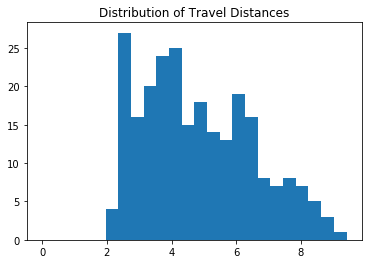

In [9]:
plt.hist(td_all, bins = 24, range = [0, max(td_all)])
plt.title("Distribution of Travel Distances")
plt.show()

In [10]:
# Object Distance (OD)
od_all = []

for lay in layouts:
    for i in range(len(lay)):
        for j in range(i):
            od_all.append(lay[i].dist(lay[j]))

print(f"{len(od_all)} object distances")

750 object distances


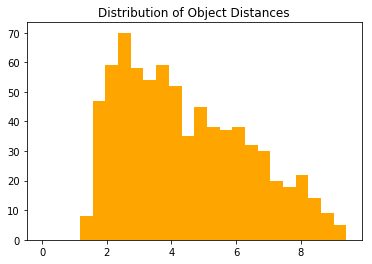

In [11]:
plt.hist(od_all, bins = 24, range = [0, max(od_all)], color = "orange")
plt.title("Distribution of Object Distances")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
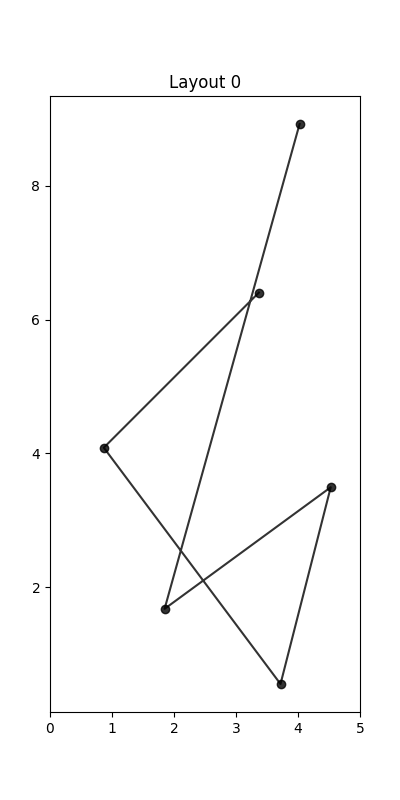

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
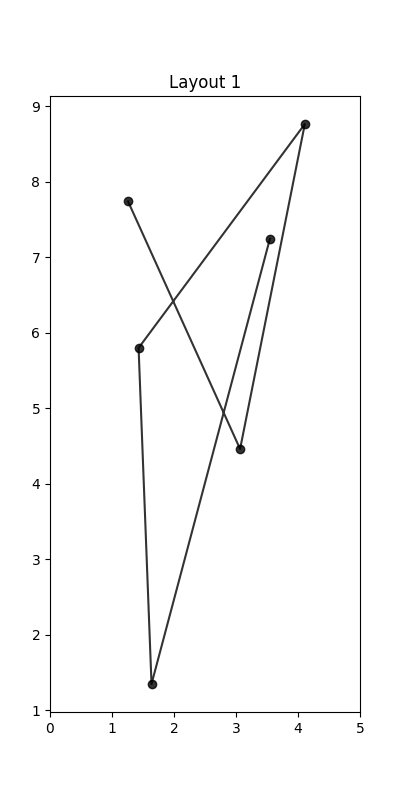

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
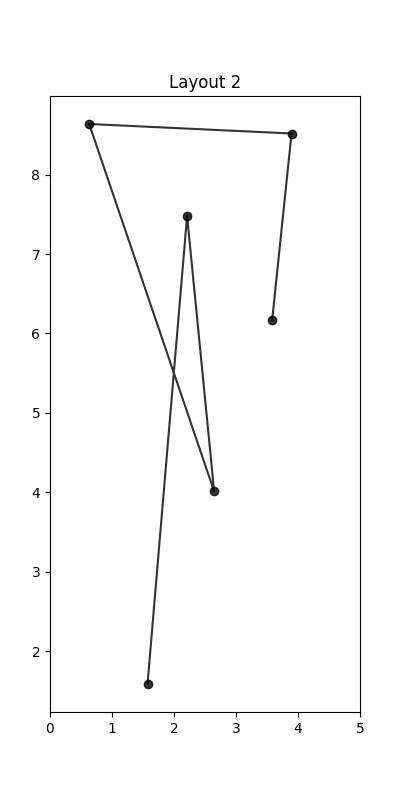

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
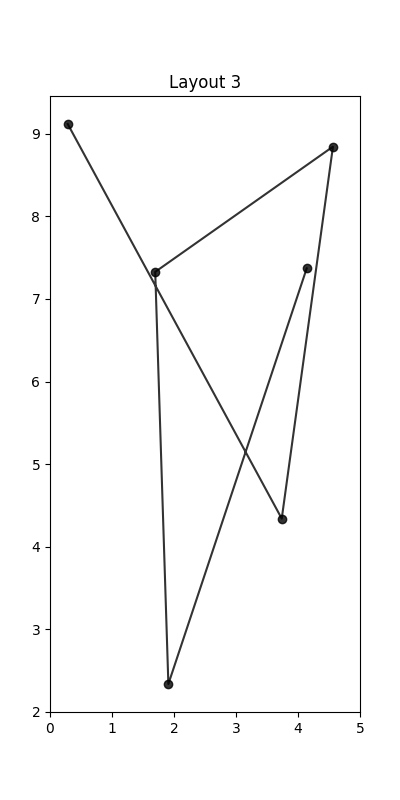

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
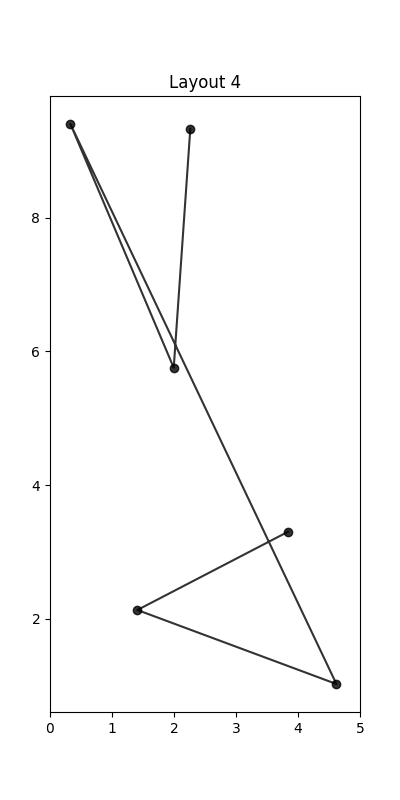

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
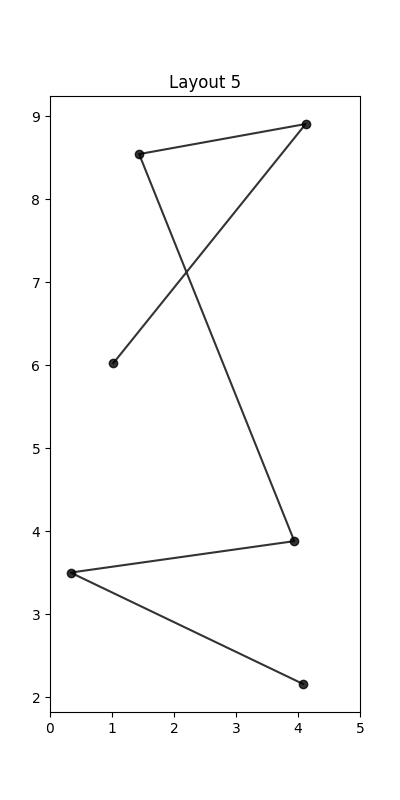

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
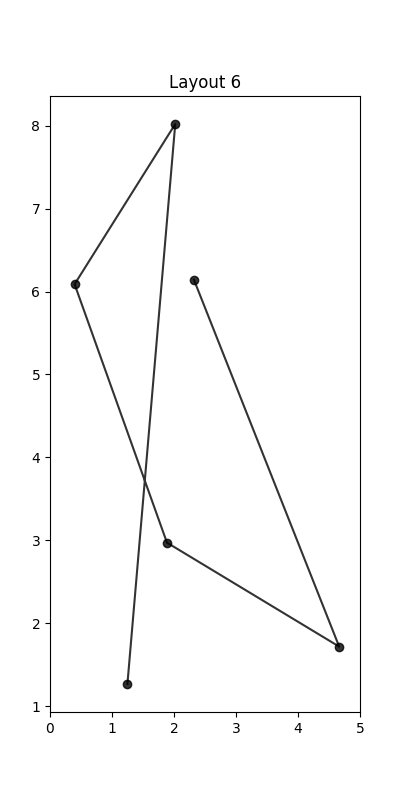

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
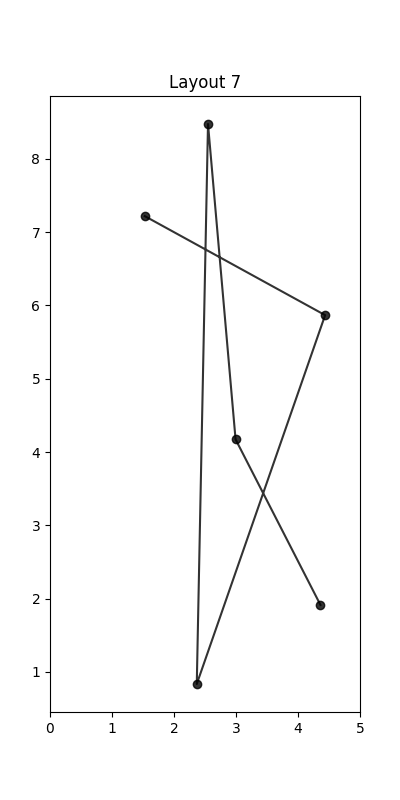

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
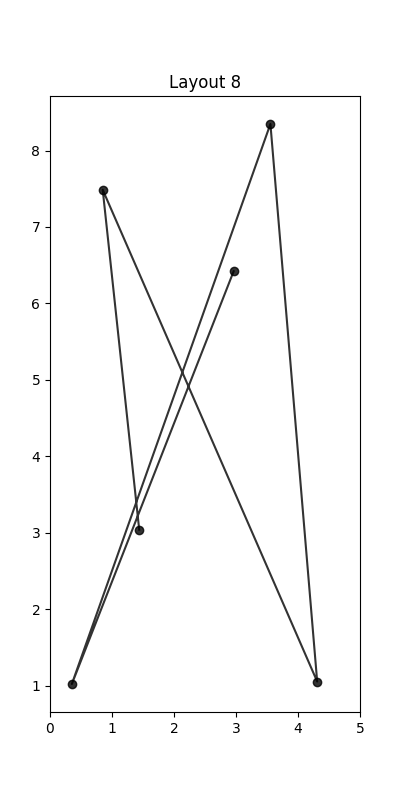

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
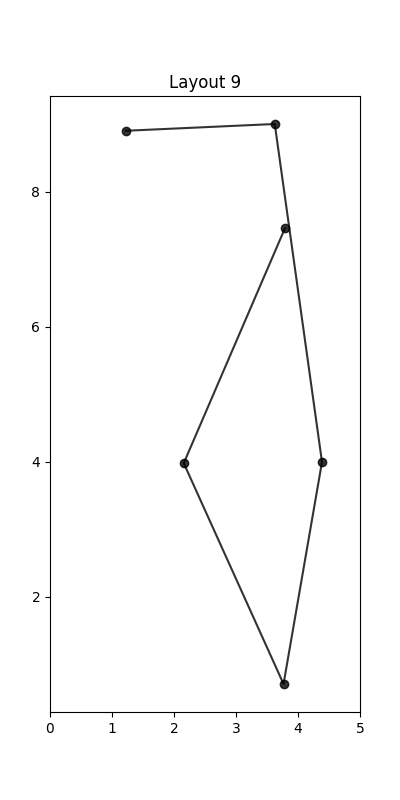

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
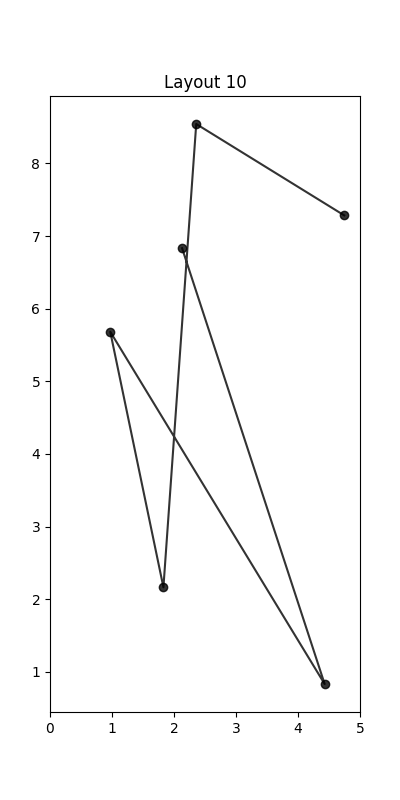

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
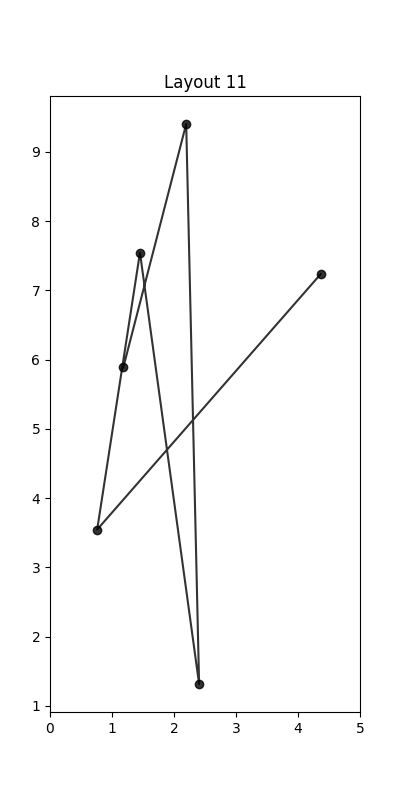

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
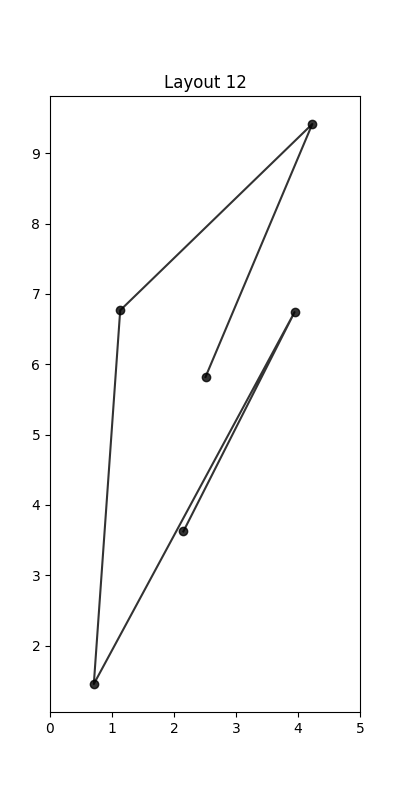

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
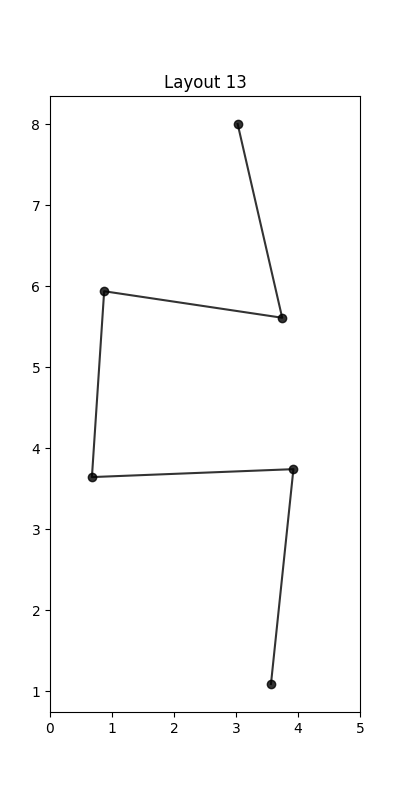

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
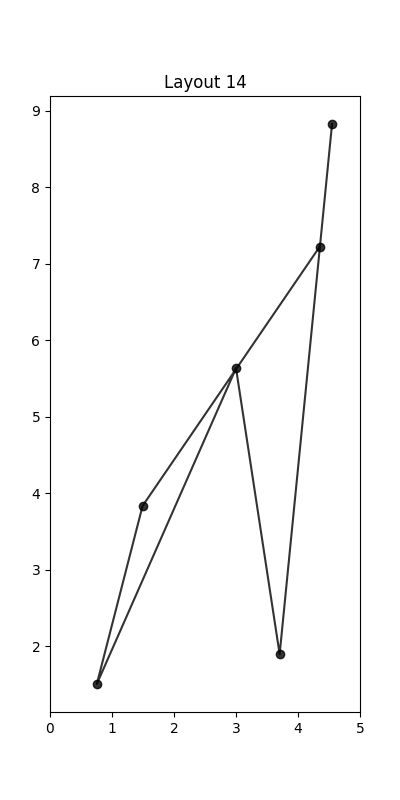

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
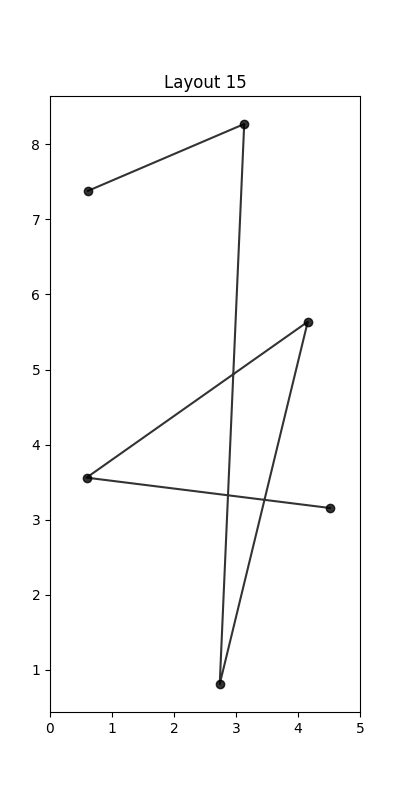

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
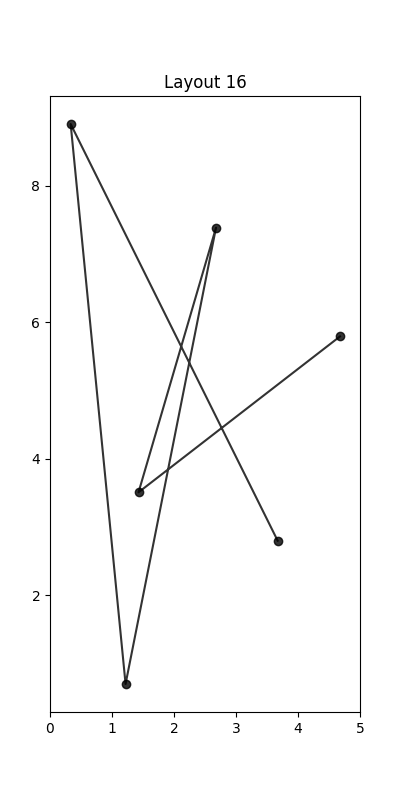

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
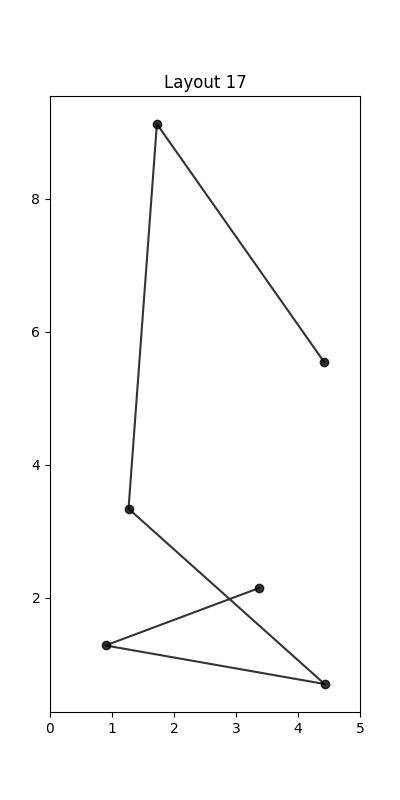

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
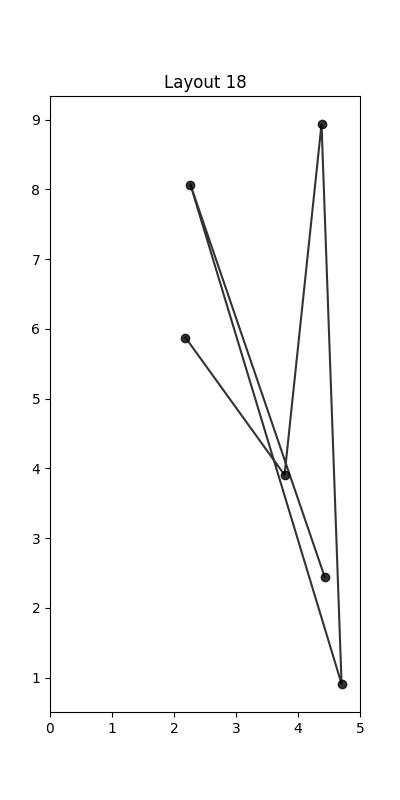

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
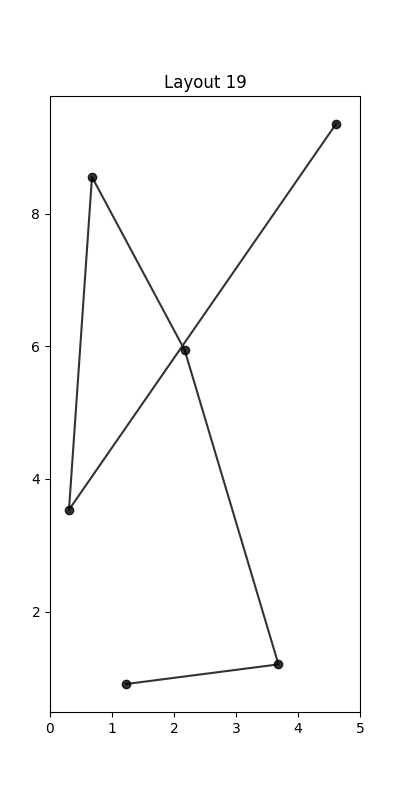

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
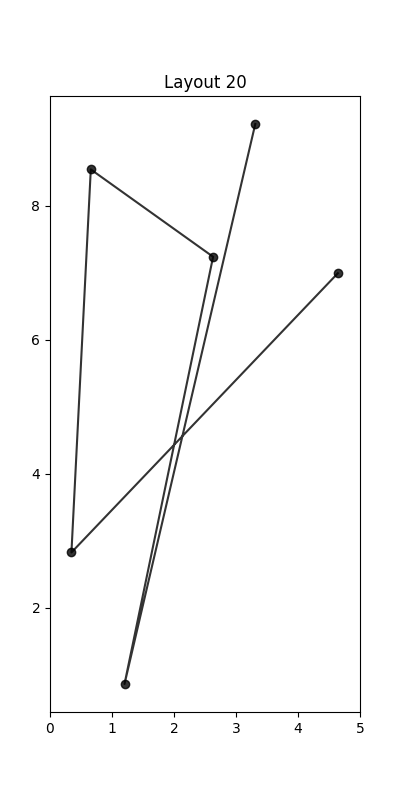

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
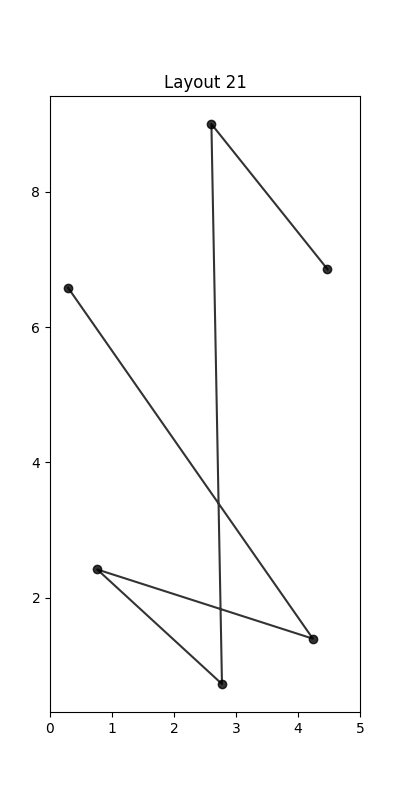

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
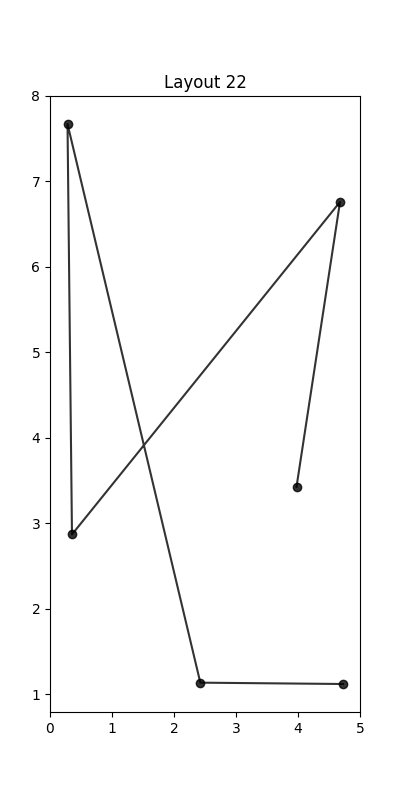

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
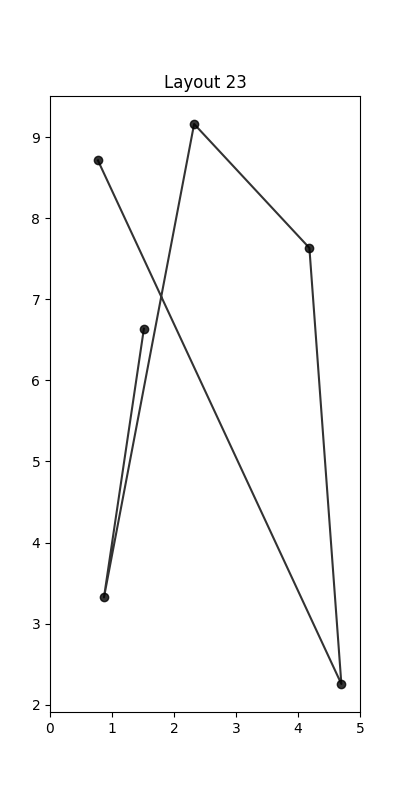

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
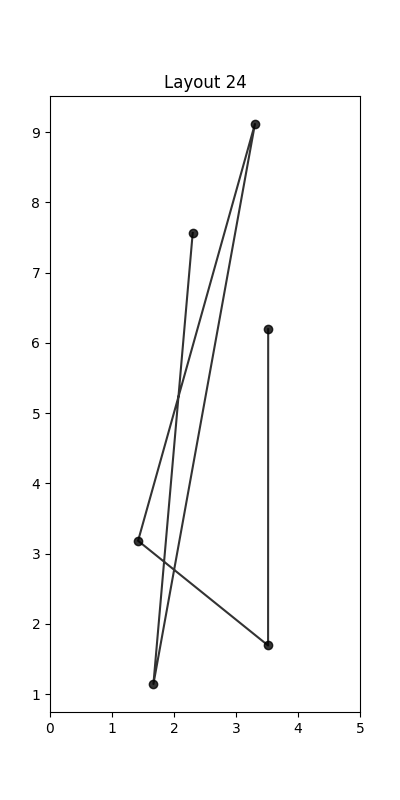

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
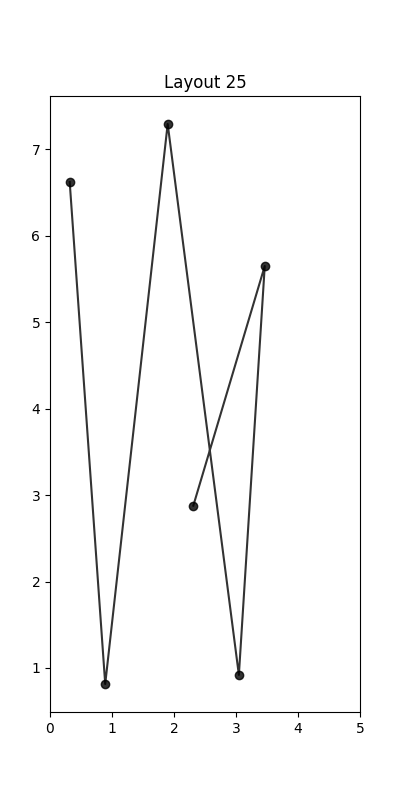

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
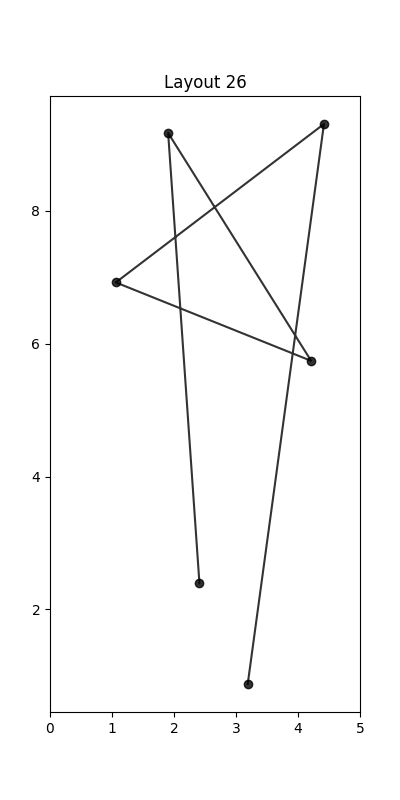

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
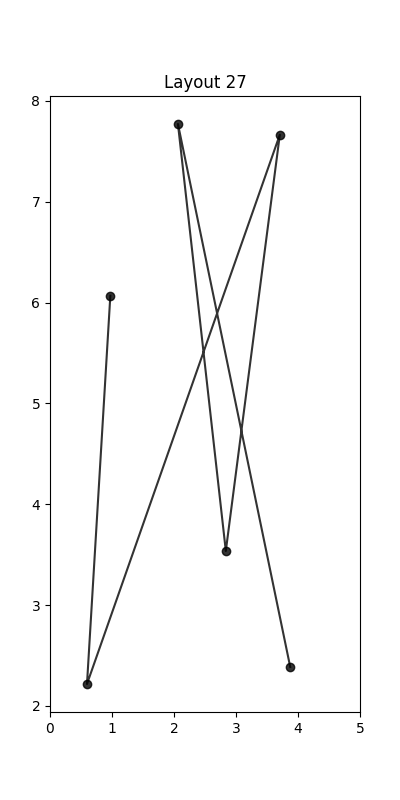

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
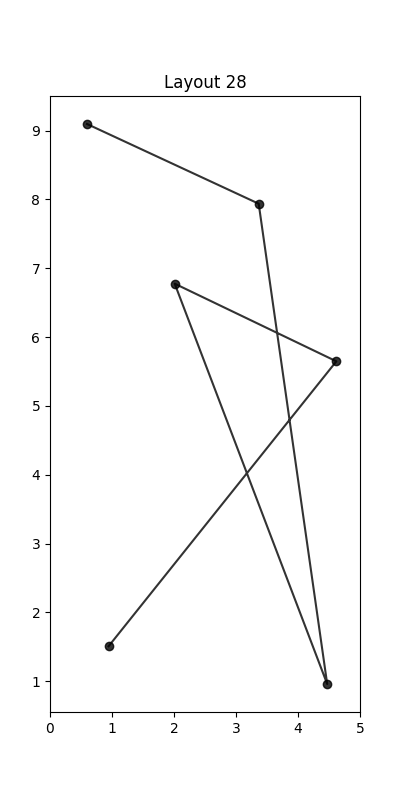

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
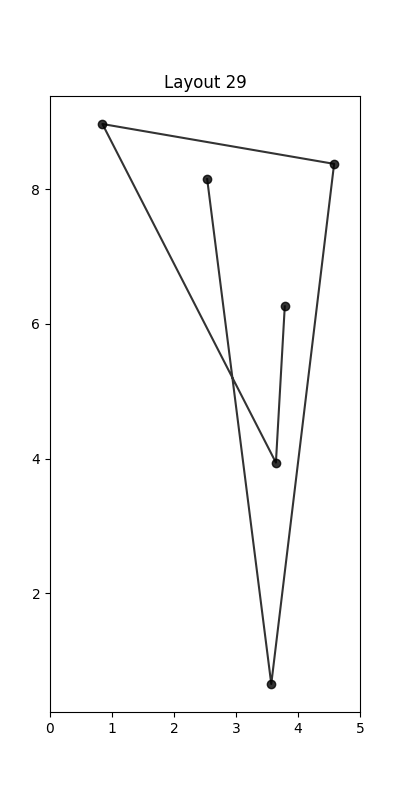

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
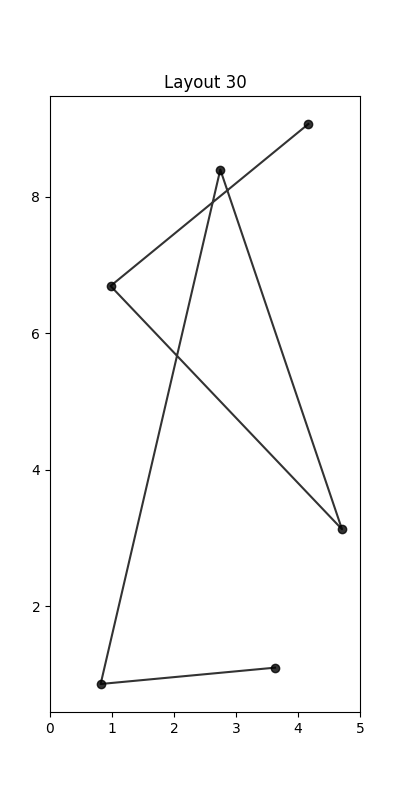

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
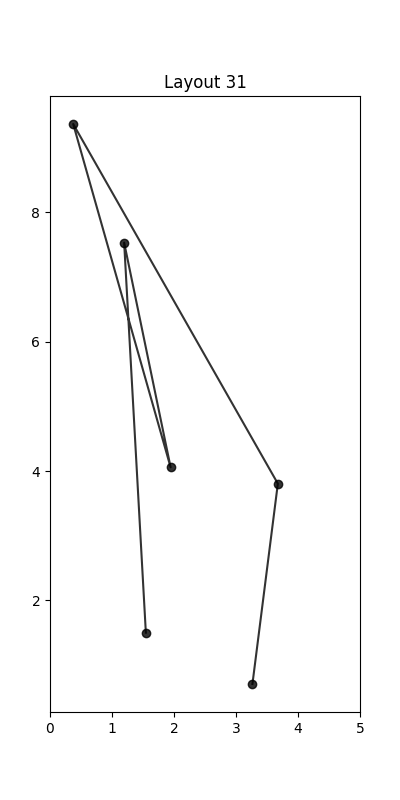

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
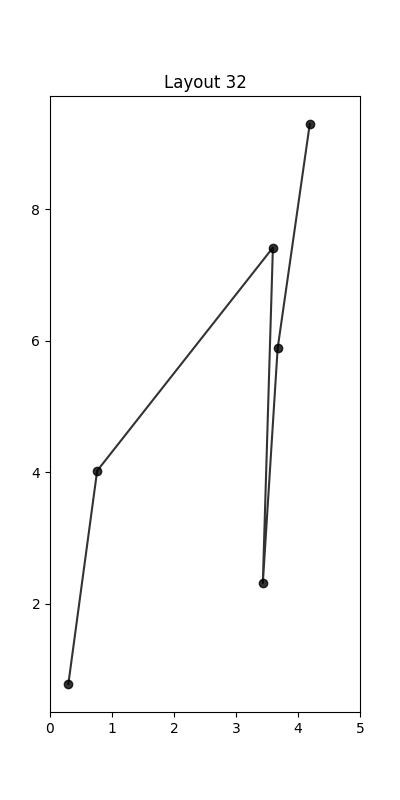

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
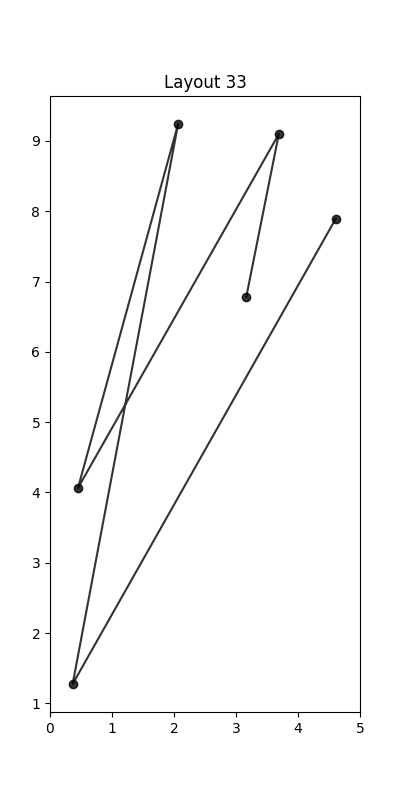

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
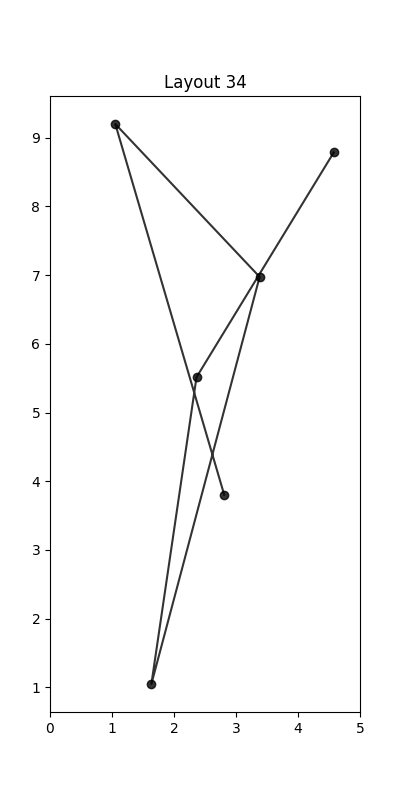

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
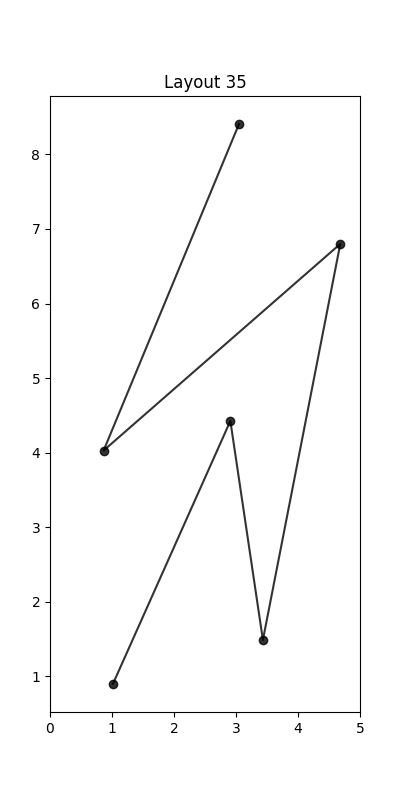

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
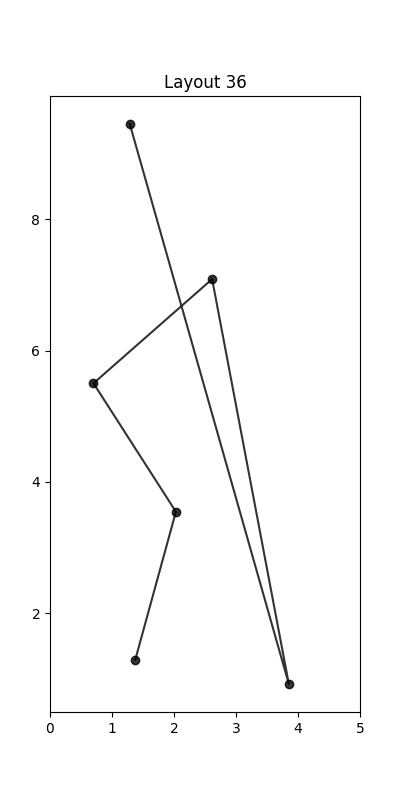

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
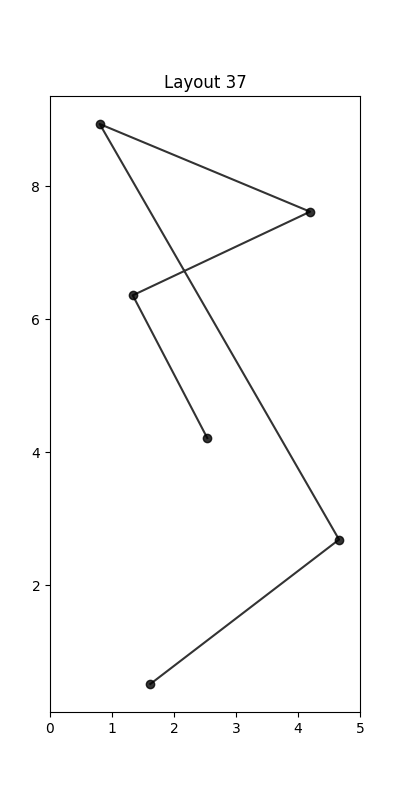

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
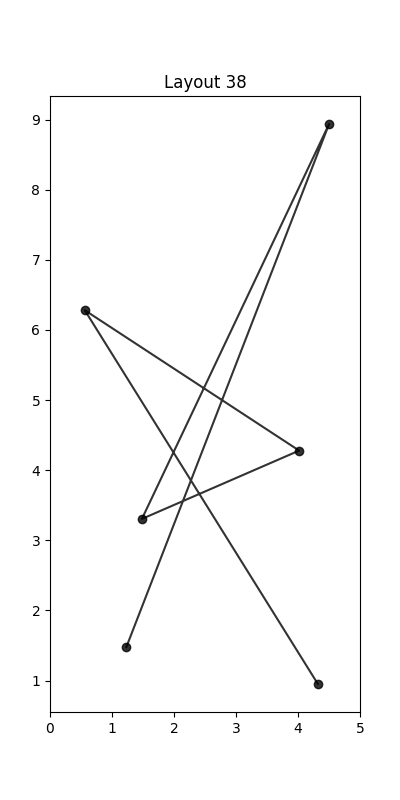

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
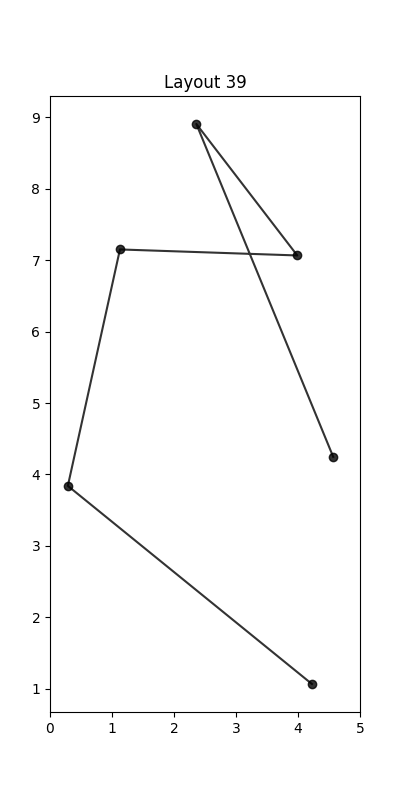

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
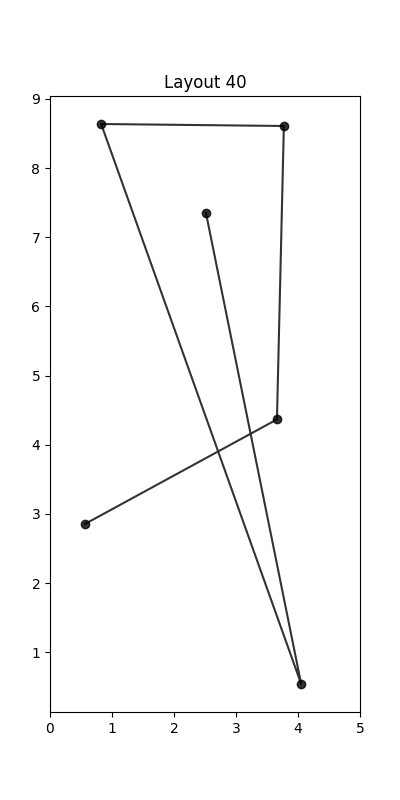

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
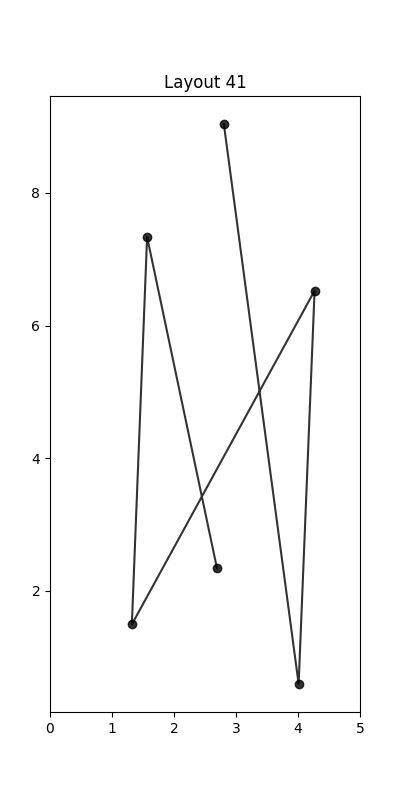

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
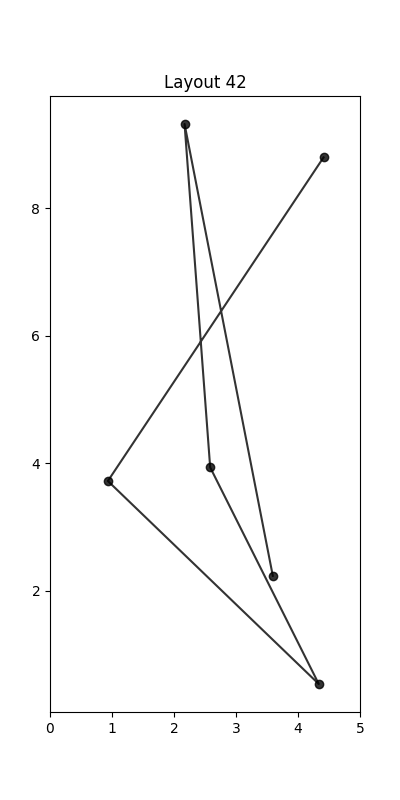

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
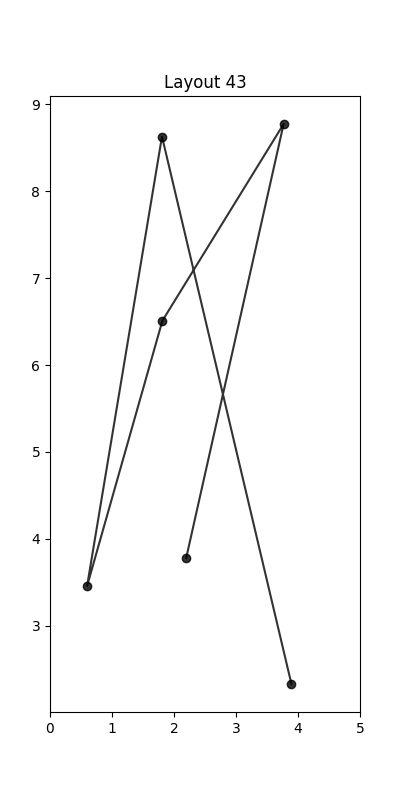

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
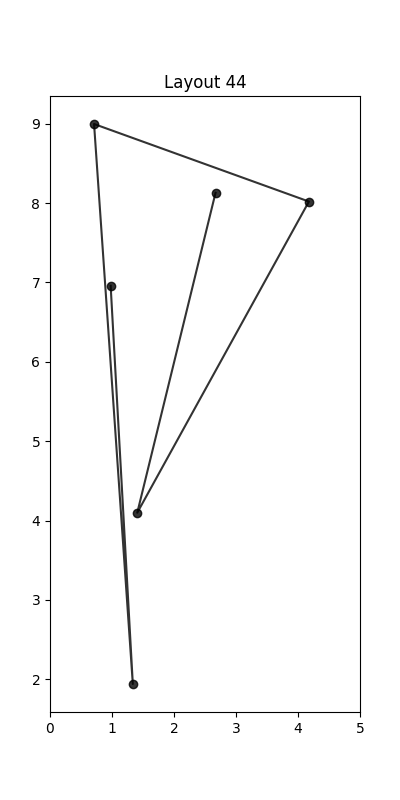

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
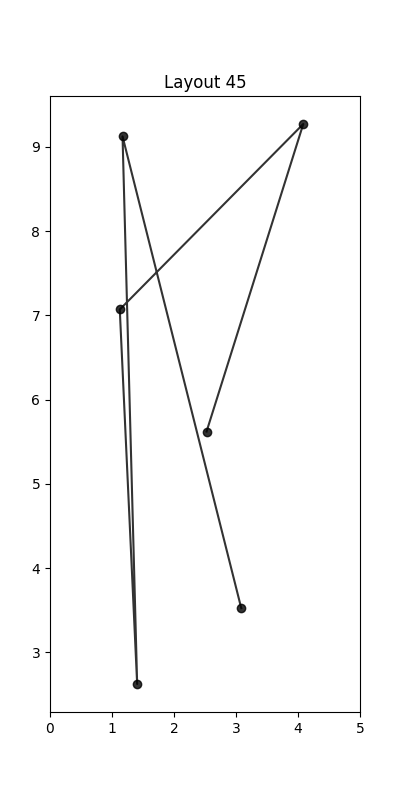

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
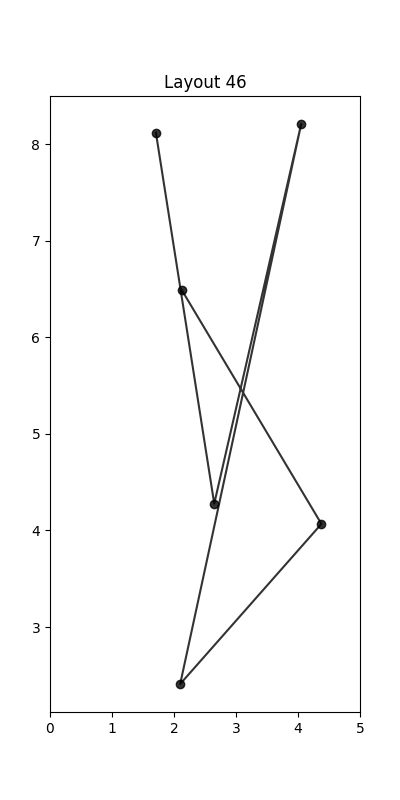

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
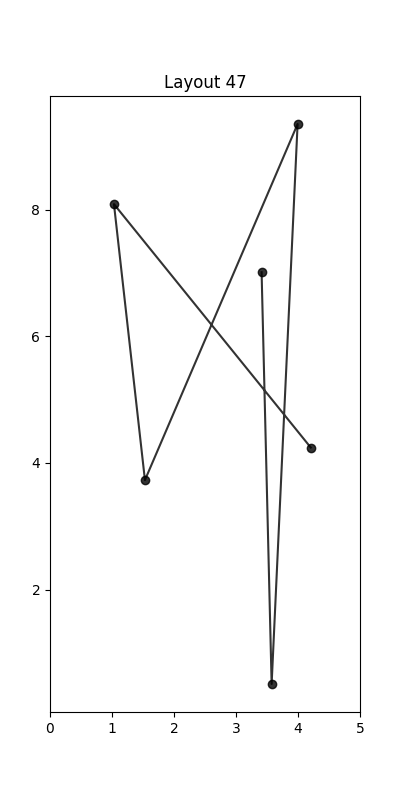

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
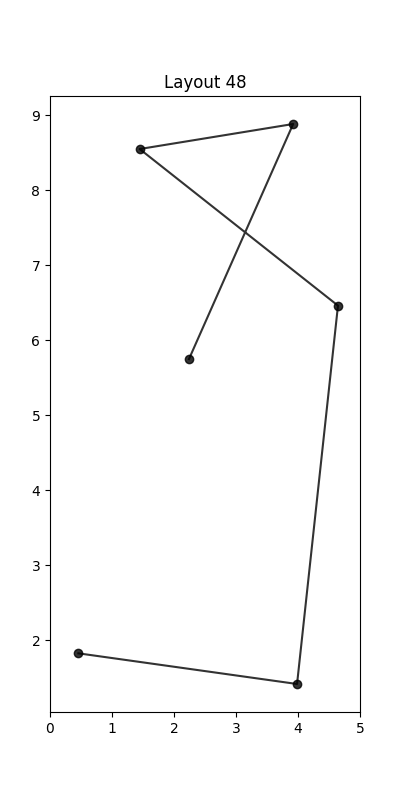

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
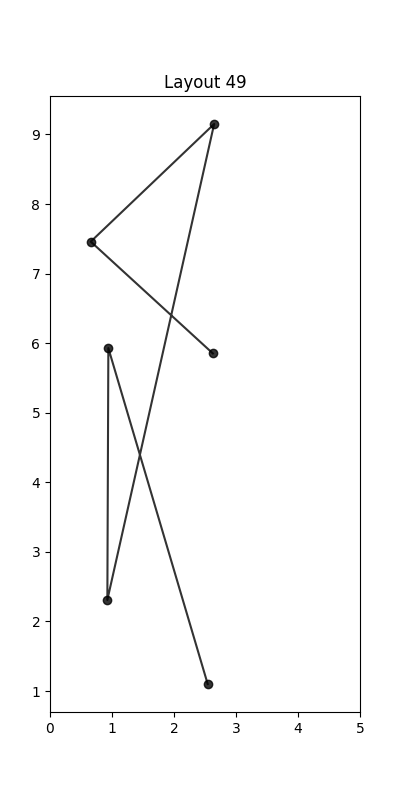

In [35]:
for i, lay in enumerate(layouts):
    fig, axs = plt.subplots(figsize = (4, 8))
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.8)
    plt.xlim([0, WIDTH])
    plt.title(f"Layout {i}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
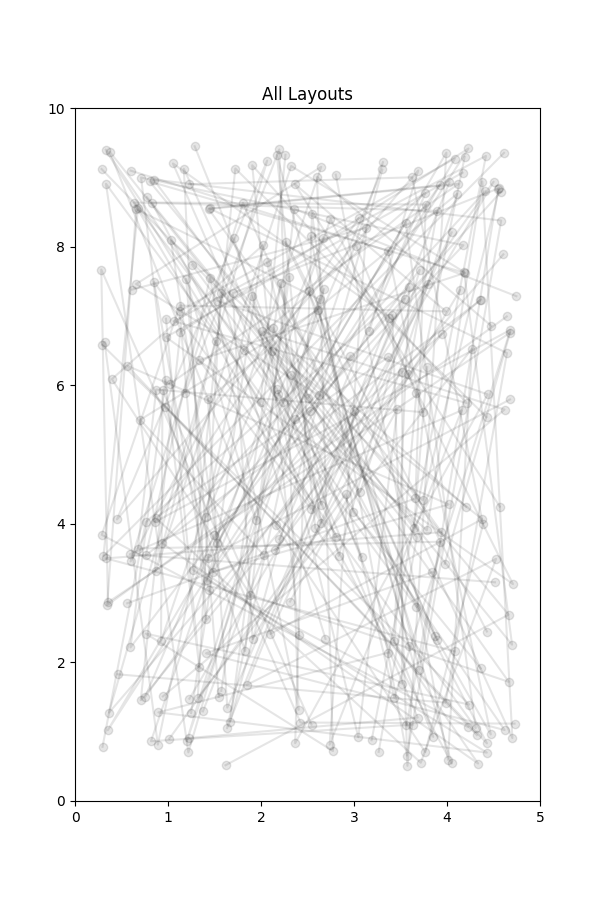

In [16]:
fig, axs = plt.subplots(figsize = (6, 9))
for lay in layouts:
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.1)
plt.title("All Layouts")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

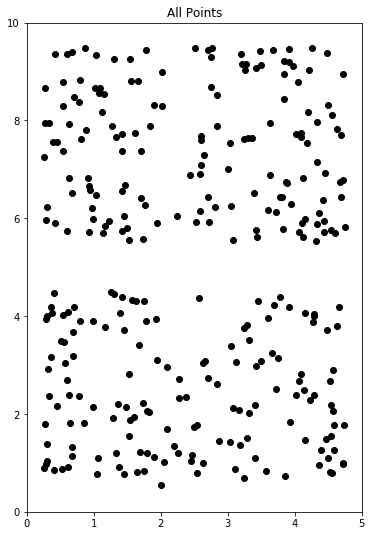

In [72]:
fig, axs = plt.subplots(figsize = (6, 9))
for lay in layouts:
    plt.scatter([p.x for p in lay], [p.y for p in lay], color = "k")
plt.title("All Points")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

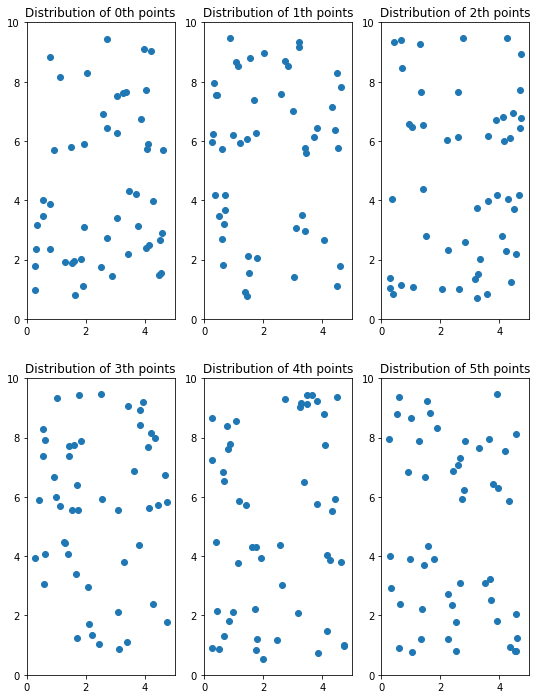

In [76]:
# Distribution of different points in a layout sequence
fig, axs = plt.subplots(2, 3, figsize = (9, 12))
for i in range(N_POINTS_LAYOUT):
    ith_ps = [layouts[j][i] for j in range(N_LAYOUTS)]
    xs, ys = [p.x for p in ith_ps], [p.y for p in ith_ps]
    axs[i//3, i%3].scatter(xs, ys)
    axs[i//3, i%3].set_xlim([0, WIDTH])
    axs[i//3, i%3].set_ylim([0, LENGTH])
    axs[i//3, i%3].set_title(f"Distribution of {i}th points")

# Dynamic Trial Shuffling
- We shuffle the N trials such that the boundary visibility alternates each time.

## Checks

- At least K = 5 trials between trials of the same pairing.
- We make sure that approx. half the pairs happen in A->B, and the other half happens in B->A
- We make sure that between adjacent pairs, the ending location and starting location is always opposite.
- We want to check the number of objects within the same cells across a sliding window of 5 trials.

# Objects
- 5 different shapes (circle, cube, cylinder, pyramid, star)
- 5 different colors from a color-blind-friendly palette.
-> 25 different combinations.

Any object generated must not have been in the last 10 shown object.